# Project 2a: Training Neural Networks for NLP Tasks


Through the previous exercises we have already used some form of neural networks through the glove and sentence transformer embeddings, which were just activations from a pre-trained neural network. In this exercise we learn how to build neural networks from scratch using Pytorch and train them to solve NLP tasks. While neural networks come in different flavors, in this assignment we will focus on the simplest form of neural networks - feedforward neural networks or multi-layered perceptron.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import json
import re
from typing import List, Tuple, Dict, Union
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nn_tests import (
    Exercise1Runner,
    Exercise2Runner,
    Exercise3Runner,
    Exercise4Runner,
    Exercise5Runner,
    Exercise6Runner,
)

In [ ]:
parent_dir = os.path.dirname(os.path.abspath("__file__"))
data_dir = os.path.join(parent_dir, "data")

In [ ]:
%%bash
wget https://homes.cs.washington.edu/~kahuja/cse447/project2/glove.6B.50d.txt -O data/embeddings/glove.6B/glove.6B.50d.txt

## Part 1: Feedforward Neural Networks for Text Classification

This part would more or less serve as a tutorial for building neural networks using Pytorch. We will be working with the Stanford Sentiment Treebank (SST) dataset that hopefully you should be very familiar with by now.

In [ ]:
# We start by loading the SST dataset
train_df_binary = pd.read_csv(
    f"{data_dir}/sst/sst_train_binary.csv"
)
dev_df_binary = pd.read_csv(
    f"{data_dir}/sst/sst_dev_binary.csv"
)

train_df_multiclass = pd.read_csv(
    f"{data_dir}/sst/sst_train_multiclass.csv"
)
dev_df_multiclass = pd.read_csv(
    f"{data_dir}/sst/sst_dev_multiclass.csv",
)

We will be using sentence representations from the Glove Embeddings (sum of the words) and sentence transformers.

In [ ]:
class GloveEmbeddings:

    def __init__(self, path="embeddings/glove.6B/glove.6B.50d.txt"):
        self.path = path
        self.vec_size = int(re.search(r"\d+(?=d)", path).group(0))
        self.embeddings = {}
        self.load()

    def load(self):
        for line in open(self.path, "r"):
            values = line.split()

            word_len = len(values) - self.vec_size

            word = " ".join(values[:word_len])
            vector_values = list(map(float, values[word_len:]))

            word = values[0]
            vector_values = list(map(float, values[-self.vec_size :]))
            vector = torch.tensor(vector_values, dtype=torch.float)
            self.embeddings[word] = vector

    def is_word_in_embeddings(self, word):
        return word in self.embeddings

    def get_vector(self, word):
        if not self.is_word_in_embeddings(word):
            return self.embeddings["unk"]
        return self.embeddings[word]

    # Use square operator to get the vector of a word
    def __getitem__(self, word):
        return self.get_vector(word)

glove_embeddings = GloveEmbeddings(
    path=f"{data_dir}/embeddings/glove.6B/glove.6B.50d.txt"
)

In [ ]:
# Paste your code from previous exercise to compute Glove Embeddings of a sentence


def cosine_similarity(v1: torch.Tensor, v2: torch.Tensor) -> float:
    """
    Compute the cosine similarity between two vectors.

    Inputs:
    v1: torch.Tensor of shape (n,)
    v2: torch.Tensor of shape (n,)

    Returns:
    float: cosine similarity between v1 and v2
    """

    # YOUR CODE HERE
    raise NotImplementedError()


def get_sentence_embedding(
    sentence: str,
    word_embeddings: GloveEmbeddings,
    use_POS: bool = False,
    pos_weights: Dict[str, float] = None,
):
    """
    Compute the sentence embedding using the word embeddings.

    Inputs:
    - sentence: The input sentence
    - word_embeddings: GloveEmbeddings object
    - use_POS: Whether to use POS tagging
    - pos_weights: Dictionary containing POS weights

    Returns:
    torch.Tensor: The sentence embedding
    """

    sentence_embedding = None

    # YOUR CODE HERE
    raise NotImplementedError()

    return sentence_embedding


def get_sentence_similarity(
    sentence1: str,
    sentence2: str,
    word_embeddings: GloveEmbeddings,
    use_POS: bool = False,
    pos_weights: Dict[str, float] = None,
):
    """
    Compute the similarity between two sentences.

    Inputs:
    - sentence1: The first input sentence
    - sentence2: The second input sentence
    - word_embeddings: GloveEmbeddings object
    - use_POS: Whether to use POS tagging
    - pos_weights: Dictionary containing POS weights

    Returns:
    float: The similarity between the two sentences
    """

    similarity = None

    # YOUR CODE HERE
    raise NotImplementedError()

    return similarity

In [ ]:
# We provide you the code to get sentence transformer embeddings

from sentence_transformers import SentenceTransformer


def get_st_embeddings(
    sentences: List[str],
    st_model: SentenceTransformer,
    batch_size: int = 32,
    device: str = "cpu",
):
    """
    Compute the sentence embedding using the Sentence Transformer model.

    Inputs:
    - sentence: The input sentence
    - st_model: SentenceTransformer model
    - batch_size: Encode in batches to avoid memory issues in case multiple sentences are passed

    Returns:
    torch.Tensor: The sentence embedding of shape [d,] (when only 1 sentence) or [n, d] where n is the number of sentences and d is the embedding dimension
    """

    st_model.to(device)
    sentence_embeddings = None

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i : i + batch_size]
        batch_embeddings = st_model.encode(batch_sentences, convert_to_tensor=True)
        if sentence_embeddings is None:
            sentence_embeddings = batch_embeddings
        else:
            sentence_embeddings = torch.cat(
                [sentence_embeddings, batch_embeddings], dim=0
            )

    return sentence_embeddings.to("cpu")

In [ ]:
get_sentence_embedding(train_df_binary["sentence"][0], glove_embeddings, use_POS=False)

In [ ]:
train_df_binary["sentence"]

In [ ]:
# Let's embed the sentences in training and validation data using Glove and Sentence Transformers

X_train_glove = torch.stack(
    [
        get_sentence_embedding(sentence, glove_embeddings, use_POS=False)
        for sentence in train_df_binary["sentence"].values
    ]
)
X_dev_glove = torch.stack(
    [
        get_sentence_embedding(sentence, glove_embeddings, use_POS=False)
        for sentence in dev_df_binary["sentence"].values
    ]
)

st_model = SentenceTransformer("all-mpnet-base-v2")
X_train_st = get_st_embeddings(train_df_binary["sentence"].values, st_model)
X_dev_st = get_st_embeddings(dev_df_binary["sentence"].values, st_model)

y_train_binary = torch.tensor(train_df_binary["label"].values)
y_dev_binary = torch.tensor(dev_df_binary["label"].values)

y_train_multiclass = torch.tensor(train_df_multiclass["label"].values)
y_dev_multiclass = torch.tensor(dev_df_multiclass["label"].values)

In [ ]:
print("Shape of glove embeddings")
print(X_train_glove.shape, X_dev_glove.shape)
print("Shape of sentence transformer embeddings")
print(X_train_st.shape, X_dev_st.shape)

In [ ]:
# For convenience later we will store all datasets in a dictionary

datasets = {
    "binary": {
        "glove": {
            "X_train": X_train_glove,
            "X_dev": X_dev_glove,
            "y_train": y_train_binary,
            "y_dev": y_dev_binary,
        },
        "st": {
            "X_train": X_train_st,
            "X_dev": X_dev_st,
            "y_train": y_train_binary,
            "y_dev": y_dev_binary,
        },
    },
    "multiclass": {
        "glove": {
            "X_train": X_train_glove,
            "X_dev": X_dev_glove,
            "y_train": y_train_multiclass,
            "y_dev": y_dev_multiclass,
        },
        "st": {
            "X_train": X_train_st,
            "X_dev": X_dev_st,
            "y_train": y_train_multiclass,
            "y_dev": y_dev_multiclass,
        },
    },
}

### Datasets and Dataloaders in Pytorch

Pytorch provides a very useful utility called `Dataset` and `Dataloader` to load and iterate over the data. The `Dataset` class is an abstract class to wrap your data and the `Dataloader` class provides an efficient iterator over the dataset. Pytorch provides a `TensorDataset` class which is a Dataset wrapping tensors. This is useful because we can easily slice the tensors to get the data we need. Sometimes we might need to write our own custom Dataset class to load the data depending upon the data types we are dealing with, but for this assignment we will stick to using the `TensorDataset` class. If you want to learn more about defining custom `Dataset` classes, you can refer to the [official documentation](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

Below we demonstrate the effectiveness of using these classes over manually iterating over the data like we did in HW1. 

In [ ]:
# Old Way from HW1
batch_size = 32
X_train, y_train = X_train_glove.clone(), y_train_binary.clone()
# Shuffle the data
shuffle_indices = torch.randperm(X_train.size(0))
X_train, y_train = X_train[shuffle_indices], y_train[shuffle_indices]
for i in range(0, len(X_train_glove), batch_size):
    X_batch = X_train_glove[i : i + batch_size]
    y_batch = y_train_binary[i : i + batch_size]
    print(X_batch.shape, y_batch.shape)
    break



# Using Pytorch's Dataset and DataLoader classes to iterate over the data in batches
from torch.utils.data import TensorDataset, DataLoader
train_glove_dataset_binary = TensorDataset(X_train_glove, y_train_binary)
train_glove_dataloader = DataLoader(train_glove_dataset_binary, batch_size=32, shuffle=True)
for batch in train_glove_dataloader:
    X_batch, y_batch = batch
    print(X_batch.shape, y_batch.shape)
    break

In [ ]:
# We provide you a utility function that creates a dataloader for you given the embeddings and labels

def create_dataloader(
    X_embed: torch.Tensor, y: torch.Tensor, batch_size: int = 32, shuffle: bool = True
):
    """
    Create a DataLoader from the input embeddings and labels.
    
    Inputs:
    - X_embed: torch.Tensor of shape (n, d) where n is the number of samples and d is the embedding dimension
    - y: torch.Tensor of shape (n,) containing the labels
    - batch_size: Batch size
    - shuffle: Whether to shuffle the data
    """
    
    dataset = TensorDataset(X_embed, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

### Defining a neural network architecture in Pytorch

Pytorch provides very elegantly designed `torch.nn` module which contains building blocks for creating different neural network architectures. Some of the sub-modules included in `torch.nn` includes:

- `torch.nn.Linear` : Perhaps one of the simplest of the nn modules, it is used to apply a linear transformation to the data i.e. y = xA^T +b, where x is the input and y is the output of the layer. A and b are the parameters of the layer, where A is often called the weights matrix and b is the bias vector.

- `torch.nn.Conv2d`: Used to create Convolutional Layers.

- `torch.nn.Transformer`: Used to create Transformer layers

and many more. For the purposes of this assignment we will only be needing `torch.nn.Linear` to define our network.

It also supports different activation functions like:
- `torch.nn.ReLU` 
- `torch.nn.Sigmoid`
- `torch.nn.Tanh`
- `torch.nn.Softmax`



Below we demonstrate the usage of some of these modules

In [ ]:
import torch
import torch.nn as nn

# Create a linear layer that maps a 5 dimensional vector to a 3 dimensional vector
example_linear_layer = nn.Linear(5, 3)  # Initialize a linear layer
example_input = torch.rand(5)  # Create a random vector for demonstration
print(f"Input: {example_input}")
print(f"Input Shape: {example_input.shape}")
example_output = example_linear_layer(
    example_input
)  # Feed the example input to the linear layer
print(f"Linear layer output: {example_output}")
print(f"Linear layer output Shape: {example_output.shape}")

print("************************************************\n")

# We can also use linear layers with batched inputs
example_batch_input = torch.rand(
    4, 5
)  # Create an example input containing 4 inputs of 5 dimension each
print(f"Batched Input:\n {example_batch_input}")
print(f"Batched Input Shape: {example_batch_input.shape}")
example_batch_output = example_linear_layer(example_batch_input)
print(f"Linear layer batched output:\n {example_batch_output}")
print(f"Linear layer batched output Shape: {example_batch_output.shape}")

print("************************************************\n")

# Using activation functions
sigmoid_activation = nn.Sigmoid()  # Define sigmoid activation
relu_activation = nn.ReLU()  # Define relu activation

sigmoid_output = sigmoid_activation(
    example_batch_output
)  # Apply the sigmoid function to the output of the linear layer
relu_output = relu_activation(
    example_batch_output
)  # Apply the relu function to the output of the linear layer
print(f"Before Applying the activation function:\n {example_batch_output}")
print(f"After Applying the sigmoid function:\n {sigmoid_output}")
print(f"After Applying the relu function:\n {relu_output}")

print("************************************************\n")

Notice how the outputs of the nn layers also contain a `grad_fn`. This is used during backpropagation to compute the gradients which are used by the optimizer to learn the parameters of these layers. More on this soon.

### Exercise 1: Implementing a Feedforward Neural Network for Text Classification

In this exercise we will implement a simple feedforward neural network for text classification. We will be using the following architecture:


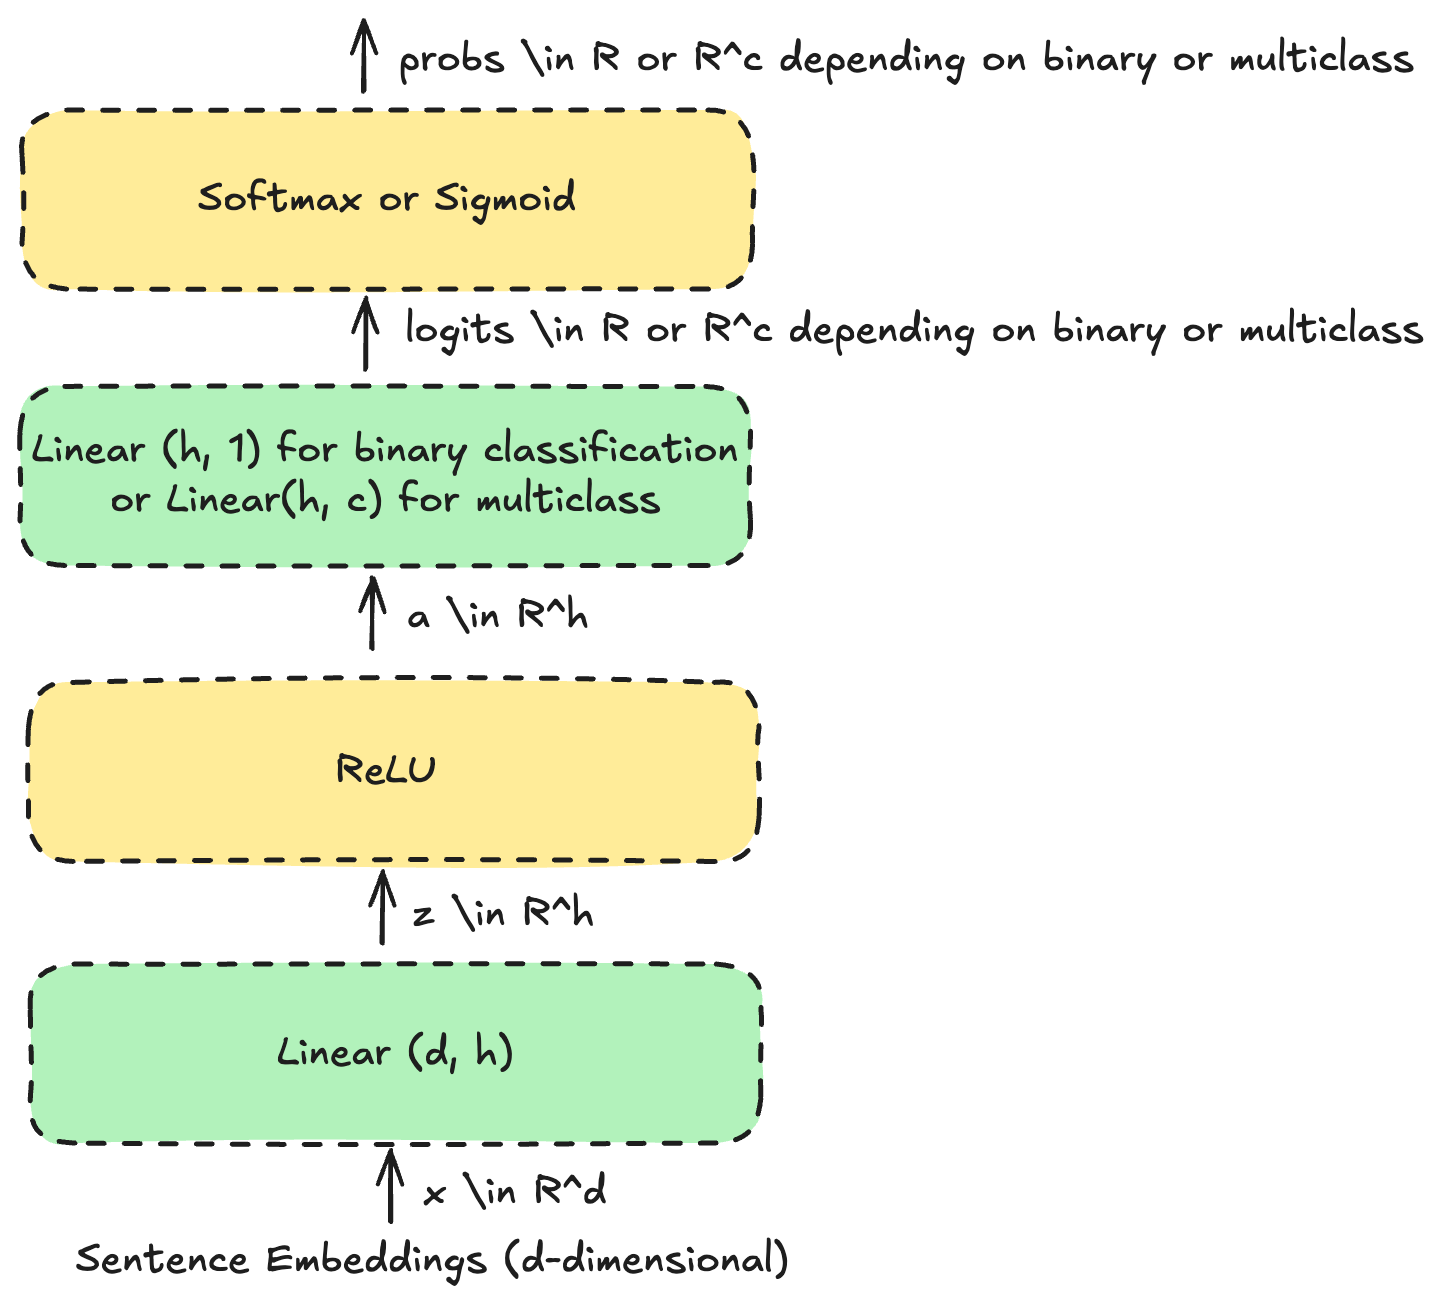


Recall from the lectures that a linear layer is defined as:

$$\pmb{z} = \pmb{W}\pmb{x} + \pmb{b}$$

where, $\pmb{z} \in \mathbb{R}^h$ is the output of the layer, $\pmb{W} \in \mathbb{R}^{h \times d}$ is the weight matrix, $\pmb{x} \in \mathbb{R}^d$ is the input to the layer and $\pmb{b} \in \mathbb{R}^{h}$ is the bias vector.

Also, the ReLU activation function is defined as:

$$\text{ReLU}(x) = \max(x, 0)$$

Note that for a vector $\pmb{x}$, the ReLU function is applied element-wise.

Some helpful hints about the exercise:

- Only return the logits from the forward pass. There is no need to apply the softmax/sigmoid function in the forward pass. It is often common to apply these functions while computing the loss function.

<!-- - You might find `nn.Sequential` helpful to define the layers of the network, but it is not necessary to use it. Read more about it [here](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). -->

- For the last layer, depending on the number of classes in the dataset, you might want to use a different number of output units. For binary classification, you can use 1 output unit. For multi-class classification, you should use the number of classes as the number of output units.

In [ ]:
class FFNN(nn.Module): # We inherit from nn.Module, which is the base class for all PyTorch Neural Network modules

    def __init__(
        self, input_dim: int, hidden_dim: int, num_classes: int
    ):

        """
        Define the architecture of a Feedforward Neural Network with architecture described above.
        
        Inputs:
        - input_dim: The dimension of the input (d according to the figure above)
        - hidden_dim: The dimension of the hidden layer (h according to the figure above)
        - num_classes: The number of classes in the classification task.
        
        """

        super(FFNN, self).__init__() # Call the base class constructor

        # Define your network architecture below

        self.fc1 = None # First linear layer
        self.act1 = None # First activation function
        self.fc2 = None # Second linear layer

        # YOUR CODE HERE
        raise NotImplementedError()

        self.initialize_weights() # Initialize the weights of the linear layers

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        """
        Computes the forward pass through the network.
        
        Inputs:
        - x : Input tensor of shape (n, d) where n is the number of samples and d is the dimension of the input
        
        Hint: You can call a layer directly with the input to get the output tensor, e.g. self.fc1(x) will return the output tensor after applying the first linear layer.
        """

        logits = None

        # YOUR CODE HERE
        raise NotImplementedError()

        return logits

    def initialize_weights(self):
        """
        Initialize the weights of the linear layers.
        
        We initialize the weights using Xavier Normal initialization and the biases to zero.
        
        You can read more about Xavier Initialization here: https://cs230.stanford.edu/section/4/#xavier-initialization
        """

        for layer in self.children():
            if type(layer) == nn.Linear:
                nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)

In [ ]:
exercise1 = Exercise1Runner(FFNN)
exercise1.evaluate()

### Defining a loss function

Now that we have implemented the model architecture, to train it we first need to define a loss function which we will minimize using an optimization algorithm. Unlike HW1 where we implemented the loss functions from scratch, we will be using the loss functions provided by Pytorch in the `torch.nn` module:
- `torch.nn.MSELoss` : Mean squared error loss function. Typically used for regression problems.
- `torch.nn.L1Loss`: Mean absolute error loss function. Like MSE loss it is also used for regression problems. Takes the mean of absolute value of the errors instead of squared values.
- `torch.nn.BCEWithLogitsLoss`: Binary Cross Entropy loss function. It is used in binary classification problems i.e. the classification problems where there are only 2 possible labels (positive and negative).
- `torch.nn.CrossEntropyLoss`: Cross Entropy loss function. Similar to BCELoss but works for multi-class classification problems as well.

You can look at the documentations of these and multiple other loss functions included in `torch.nn` package [here](https://pytorch.org/docs/stable/nn.html#loss-functions). For our purposes since we will be using `torch.nn.BCEWithLogitsLoss` for the binary case and `torch.nn.CrossEntropyLoss` for the multiclass case. Both of these loss functions take the logits (pre-softmax/sigmoid) as input and apply the softmax/sigmoid function internally.

Below we provide an example of using these loss functions.

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()  # Define the loss function

# Demonstarting usage on a random example
torch.manual_seed(42)
ffnn = FFNN(50, 100, 1)  # Initialize the FFNN model
input = torch.rand(2, 50)  # Defining a random input for demonstration
logits = ffnn(input)
labels = torch.FloatTensor([1, 0])  # Defining a random labels for demonstration
loss = loss_fn(logits.squeeze(-1), labels)
print(loss)

Notice how while calling the loss function we do `logits.squeeze(-1)`, this is done because the model outputs a tensor of shape (batch_size, 1) but the loss function expects a tensor of shape (batch_size,). The `squeeze` function is used to remove the extra dimension.

In [ ]:
loss_fn = nn.CrossEntropyLoss()  # Define the loss function

# Demonstarting usage on a random example
torch.manual_seed(42)
ffnn = FFNN(50, 100, 3)  # Initialize the FFNN model
input = torch.rand(4, 50)  # Defining a random input for demonstration
preds = ffnn(input)
labels = torch.LongTensor([0, 2, 1, 2])  # Defining a random labels for demonstration
loss = loss_fn(preds, labels)
print(loss)

Again note that the loss also contains a `grad_fn`. We can use `loss.backward()` to compute the gradients with respect to all the model parameters .

In [ ]:
print(ffnn.fc1.weight.grad)
loss.backward()
print(ffnn.fc1.weight.grad)

Notice how before calling `loss.backward()` the gradient was None, but after the call it gets populated. This is awesome, because unlike HW1 where we had to manually compute the gradients, Pytorch does it for us!

### Defining an Optimizer

Now that we have defined the model architecture and the loss function, we need to define an optimizer to learn the parameters of the model. Pytorch provides a [`torch.optim`](https://pytorch.org/docs/stable/optim.html) module which contains implementations of many optimization algorithms. Some of the most commonly used optimizers include:

- `torch.optim.SGD`: Stochastic Gradient Descent optimizer
- `torch.optim.RMSprop`: RMSprop optimizer
- `torch.optim.Adam`: Adam optimizer
- `torch.optim.Adagrad`: Adagrad optimizer

We already saw the `SGD`, which is short for Stochastic Gradient Descent optimizer in HW1. The other optimizers are more advanced versions of the SGD optimizer which are more efficient and converge faster. You can read more about how these different optimizers work [here](https://cs231n.github.io/neural-networks-3/). For this assignment we will be using the `Adam` optimizer. Below we demonstrate how to use the `Adam` optimizer.

In [ ]:
from torch.optim import Adam

torch.manual_seed(42)
# We will first need to define the model
example_model = FFNN(
    input_dim=5, hidden_dim=10, num_classes=1
)

# Defining the optimizer
example_optim = Adam(example_model.parameters(), lr=1e-3)

Notice that the optimizer takes as input two arguments, the first is the parameters of the model that are to be learned using the optimizer and the second is the learning rate . Adam optimizer also has other hyperparameters like $\beta_1$, $\beta_2$, and $\epsilon$. details of which are beyond the scope of this assignment. However, you need not worry about setting these hyper-parameters as in most of the cases the default vaues of these work well enough. Next let's see how to update the model's parameters using the optimizer.


In [ ]:
example_optim.zero_grad()  # This is done to zero-out any existing gradients stored from some previous steps
input = torch.rand(2, 5)  # Defining a random input for demonstration
logits = example_model(input)
labels = torch.FloatTensor([1, 0])  # Defining a random labels for demonstration
loss_fn = nn.BCEWithLogitsLoss()  # Define the loss function
loss = loss_fn(logits.squeeze(-1), labels)
loss.backward()  # Perform backward pass
print(f"Parameters before the update: {example_model.fc1.weight}")
example_optim.step()  # Update the parameters using the optimizer
print(f"Parameters after the update: {example_model.fc1.weight}")

As you can see after calling `example_optim.step()` the parameters get updated. Again, unlike HW1 where we had to manually update the parameters, Pytorch does it for us!

### Using GPU in Pytorch.

While not needed for this assignment, it is worth mentioning that Pytorch provides a very easy way to use the GPU for training the models, which apart from autograd is the other huge benifit of using a deep learning framework like Pytorch. Pytorch tensors and modules can be easily moved to the GPU using the `.to()` method. Below we demonstrate how to move the model and the data to the GPU.

```python

# Consider a pytorch model and a tensor X and y
model.to(device)
X = X.to(device)
y = y.to(device)

```

where `device` is a variable that can be set to `cuda` if you have a GPU or `cpu` if you don't. You can set the device using the following code:

```python
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

```

One thing to note when using devices in Pytorch is to ensure that the model and the data are on the same device. If the model is on the GPU and the data is on the CPU or vice-versa, Pytorch will throw an error.

### Exercise 2: Training and Evaluating the Feedforward Neural Network

In [ ]:
def evaluate(
    model: nn.Module,
    X_dev: torch.Tensor,
    y_dev: torch.Tensor,
    eval_batch_size: int = 128,
    device: str = "cpu",
) -> Dict[str, float]:

    """
    Evaluates the model's loss on the validation set as well as accuracy, precision, and recall scores.
    
    Inputs:
    - model: The FFNN model
    - X_dev: The sentence embeddings of the validation data
    - y_dev: The labels of the validation data
    - eval_batch_size: Batch size for evaluation
    
    Returns:
    - Dict[str, float]: A dictionary containing the loss, accuracy, precision, recall, and F1 scores
    """

    # Create a DataLoader for the validation data
    dev_dataloader = create_dataloader(X_dev, y_dev, batch_size=eval_batch_size, shuffle=False) # Note that we don't shuffle the data for evaluation.

    # A flag to check if the classification task is binary
    is_binary_cls = y_train.max() == 1

    # Set the model to evaluation mode. Read more about why we need to do this here: https://stackoverflow.com/questions/60018578/what-does-model-eval-do-in-pytorch
    model.eval()

    # Transfer the model to device
    model.to(device)

    # TODO: Define the loss function. Remember to use BCEWithLogitsLoss for binary classification and CrossEntropyLoss for multiclass classification
    loss_fn = None
    # YOUR CODE HERE
    raise NotImplementedError()

    val_loss = 0.0
    preds = [] # List to store the predictions. This will be used to compute the accuracy, precision, and recall scores.

    with torch.no_grad(): # This is done to prevent PyTorch from storing gradients, which we don't need during evaluation (which saves a lot of memory and computation)
        for X_batch, y_batch in dev_dataloader: # Iterate over the batches of the validation data

            # TODO: Perform a forward pass through the network and compute loss
            batch_loss = None
            X_batch, y_batch = X_batch.to(device), y_batch.to(device) # Transfer the data to device
            y_batch = y_batch.float() if is_binary_cls else y_batch # Convert the labels to float if binary classification
            # YOUR CODE HERE
            raise NotImplementedError()

            # TODO: Compute the predictions and store them in the preds list.
            # Remember to apply a sigmoid function to the logits if binary classification and argmax if multiclass classification
            # For binary classification, you can use a threshold of 0.5.
            batch_preds = None
            # YOUR CODE HERE
            raise NotImplementedError()

            preds.extend(batch_preds.cpu())

            val_loss += batch_loss.item() # Accumulate the loss. Note that we use .item() to extract the loss value from the tensor.
    val_loss /= len(dev_dataloader) # Compute the average loss
    preds = torch.stack(preds) # Convert the list of predictions to a tensor

    # TODO: Compute the accuracy, precision, and recall scores
    accuracy, precision, recall, f1 = None, None, None, None

    # YOUR CODE HERE
    raise NotImplementedError()

    return {
        "loss": val_loss,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }


def train(
    model: nn.Module,
    X_train_embed: torch.Tensor,
    y_train: torch.Tensor,
    X_dev_embed: torch.Tensor,
    y_dev: torch.Tensor,
    lr: float = 1e-3,
    batch_size: int = 32,
    eval_batch_size: int = 128,
    n_epochs: int = 10,
    device: str = "cpu",
    verbose: bool = True,
):

    """
    Runs the training loop for `n_epochs` epochs.
    
    Inputs:
    - model: The FFNN model to be trained
    - X_train_embed: The sentence embeddings of the training data
    - y_train: The labels of the training data
    - X_dev_embed: The sentence embeddings of the validation data
    - y_dev: The labels of the validation data
    - lr: Learning rate for the optimizer
    - n_epochs: Number of epochs to train the model
    
    Returns:
    - train_losses: List of training losses for each epoch
    - dev_metrics: List of validation metrics (loss, accuracy, precision, recall, f1) for each epoch
    """

    # Create a DataLoader for the training data
    train_dataloader = create_dataloader(X_train_embed, y_train, batch_size=batch_size, shuffle=True)

    # A flag to check if the classification task is binary
    is_binary_cls = y_train.max() == 1

    # Transfer the model to device
    model.to(device)

    # TODO: Define the loss function. Remember to use BCEWithLogitsLoss for binary classification and CrossEntropyLoss for multiclass classification
    loss_fn = None
    # YOUR CODE HERE
    raise NotImplementedError()

    # TODO: Define the optimizer
    optimizer = None
    # YOUR CODE HERE
    raise NotImplementedError()

    train_losses = [] # List to store the training losses
    dev_metrics = [] # List to store the validation metrics

    for epoch in range(n_epochs): # Iterate over the epochs

        model.train() # Set the model to training mode
        train_epoch_loss = 0.0
        for X_batch, y_batch in train_dataloader: # Iterate over the batches of the training data

            optimizer.zero_grad()  # This is done to zero-out any existing gradients stored from previous steps
            X_batch, y_batch = X_batch.to(device), y_batch.to(device) # Transfer the data to device
            y_batch = y_batch.float() if is_binary_cls else y_batch # Convert the labels to float if binary classification
            # TODO: Perform a forward pass through the network and compute loss
            batch_loss = None
            # YOUR CODE HERE
            raise NotImplementedError()

            # TODO: Perform a backward pass and update the weights
            # YOUR CODE HERE
            raise NotImplementedError()

            # TODO: Perform a step of optimization
            # YOUR CODE HERE
            raise NotImplementedError()

            train_epoch_loss += batch_loss.item()

        train_epoch_loss /= len(train_dataloader)
        train_losses.append(train_epoch_loss)

        eval_metrics = evaluate(model, X_dev_embed, y_dev, eval_batch_size=eval_batch_size, device=device)
        dev_metrics.append(eval_metrics)

        if verbose:
            print("Epoch: %.d, Train Loss: %.4f, Dev Loss: %.4f, Dev Accuracy: %.4f, Dev Precision: %.4f, Dev Recall: %.4f, Dev F1: %.4f" % (epoch + 1, train_epoch_loss, eval_metrics["loss"], eval_metrics["accuracy"], eval_metrics["precision"], eval_metrics["recall"], eval_metrics["f1"]))
            # print(f"Epoch: {epoch + 1}, Train Loss: {train_epoch_loss}, Dev Loss: {eval_metrics['loss']}, Dev Accuracy: {eval_metrics['accuracy']}, Dev Precision: {eval_metrics['precision']}, Dev Recall: {eval_metrics['recall']}, Dev F1: {eval_metrics['f1']}")

    return train_losses, dev_metrics

In [ ]:
exercise2 = Exercise2Runner(train, FFNN=FFNN, datasets=datasets)
nn_glove_binary_model, nn_glove_binary_train_losses, nn_glove_binary_dev_metrics = exercise2.evaluate("glove",multiclass=False, device="cpu") # Change device to "cuda" if you have a GPU

You should see the following metrics at the end of training:

| Metric        | Value                 |
|---------------|-----------------------|
| Training Loss | 0.5231                |
| Dev Loss      | 0.5350                |
| Dev Accuracy  | 0.7530                |
| Dev Precision | 0.7312                |
| Dev Recall    | 0.6126                |
| Dev F1 Score  | 0.6667                |

Notice that this is the best dev accuracy for this task that we have had without using any pre-trained sentence transformer based embeddings. Now let's see the performance of a model that uses sentence transformer embeddings.

In [ ]:
nn_st_binary_model, nn_st_binary_train_losses, nn_st_binary_dev_metrics = (
    exercise2.evaluate("st", multiclass=False, device="cpu")
)  # Change device to "cuda" if you have a GPU

You should observe the following metrics
| Metric        | Value                 |
|---------------|-----------------------|
| Training Loss | 0.3244                |
| Dev Loss      | 0.3676                |
| Dev Accuracy  | 0.8283                |
| Dev Precision | 0.7662                |
| Dev Recall    | 0.8266                |
| Dev F1 Score  | 0.7952                |

Now let's train for the multiclass case for both the glove embeddings and the sentence transformer embeddings.

In [ ]:
nn_glove_multiclass_model, nn_glove_multiclass_train_losses, nn_glove_multiclass_dev_metrics = (
    exercise2.evaluate("glove", multiclass=True, device="cpu")
)  # Change device to "cuda" if you have a GPU

In [ ]:
nn_st_multiclass_model, nn_st_multiclass_train_losses, nn_st_multiclass_dev_metrics = (
    exercise2.evaluate("st", multiclass=True, device="cpu")
)  # Change device to "cuda" if you have a GPU

These should be the metrics for the two embedding types for the multiclass case:

| Metric                           | Glove Embeddings | Sentence Transformer Embeddings |
|----------------------------------|------------------|---------------------------------|
| Training Loss                    | 1.3429           | 1.0622                          |
| Dev Loss                         | 1.4027           | 1.1170                          |
| Dev Accuracy                     | 0.3678           | 0.5014                          |
| Dev Precision                    | 0.3854           | 0.5090                          |
| Dev Recall                       | 0.3588           | 0.4673                          |
| Dev F1 Score                     | 0.3716           | 0.4873                          |


Note that we are using `Exercise2Runner` here to run your code to assist with autograding. If you want to experiment with different hyperparameters, you can directly train models without using `Exercise2Runner`. Here's how you can do that:

```python
# Define the model

nn_model = FeedForwardNN(
    input_dim=50, # Change this to 768 if you want to train with sentence transformer embeddings
    hidden_dim=100, # You can change this to any number of hidden units you want
    num_classes=1 # You can change this to the number of classes for the multiclass case
)

# Train the model
train_losses, dev_metrics = train(
    nn_model,
    X_train_embed=X_train_glove, # You can change this to X_train_st if you want to train with sentence transformer embeddings
    y_train=y_train_binary, # You can change this to y_train_multiclass if you want to train for multiclass classification
    X_dev_embed=X_dev_glove, # You can change this to X_dev_st if you want to train with sentence transformer embeddings
    y_dev=y_dev_binary, # You can change this to y_dev_multiclass if you want to train for multiclass classification
    lr=1e-5, # You can change this to any learning rate you want
    n_epochs=10, # You can change this to any number of epochs you want to train for
    batch_size=32, # You can change this to any batch size you want
    device='cpu' # You can change this to 'cuda' if you have a GPU
    verbose=True
)

```

### Exercise 3: Making Predictions

In practice it can be useful to have a method that takes in raw text and returns the predicted class. In this exercise you will implement the `predict` method which takes in a list of strings and returns the predicted class for each string.

In [ ]:
def predict(
    sentences: List[str],
    model: nn.Module,
    embedding_method: str = "glove",
    batch_size: int = 32,
    device: str = "cpu",
    **kwargs,
):
    
    """
    Predicts the labels for the input sentences using the trained model.
    
    Inputs:
    - sentences: List of input sentences
    - model: The trained FFNN model
    - embedding_method: The embedding method used to embed the sentences. Can be "glove" or "st"
    - batch_size: Batch size for prediction
    
    Returns:
    - List[int]: List of predicted labels
    """
    
    assert embedding_method in ["glove", "st"], "embedding_method should be either 'glove' or 'st'"
    
    if embedding_method == "glove":
        glove_embeddings = kwargs.get("glove_embeddings", GloveEmbeddings(path=f"{data_dir}/embeddings/glove.6B/glove.6B.50d.txt"))
    else:
        st_model = kwargs.get("st_model", SentenceTransformer("all-mpnet-base-v2"))
        
    # TODO: Embed the sentences
    # YOUR CODE HERE
    raise NotImplementedError()
    
    # TODO: Make predictions
    model.to(device)
    model.eval()
    preds = [] # List to store the predictions. Note that the prediction should be the final predicted class and not the logits or probabilities.
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return preds

In [ ]:
predict(
    ["This movie is great!", "This movie is terrible!"],
    nn_glove_binary_model,
    embedding_method="glove",
    device="cpu",
    glove_embeddings=glove_embeddings,
)

In [ ]:
exercise3 = Exercise3Runner(
    predict,
    models = {"binary": {"glove": nn_glove_binary_model, "st": nn_st_binary_model}, "multiclass": {"glove": nn_glove_multiclass_model, "st": nn_st_multiclass_model}}, 
    glove_embeddings=glove_embeddings,
    st_model=st_model
)
exercise3.evaluate(multiclass=False, device="cpu", print_q=True) # Change device to "cuda" if you have a GPU

You should expect the same accuracies that you observed in the previous exercise. This is just to sanity check that your predict method is working correctly.

In [ ]:
exercise3.evaluate(
    multiclass=True, device="cpu", print_q=True
)  # Change device to "cuda" if you have a GPU

### Saving the model

It is often very useful to save the model after training so that it can be used later for making predictions. Pytorch provides a very easy way to save the model using the `torch.save` function. Below we demonstrate how to save the model.

```python

# Save the model
torch.save(nn_model.state_dict(), '{{path_where_to_save}}/model.pt')

```

where `{{path_where_to_save}}` is the path where you want to save the model. You can load the model later using the `torch.load` function.

```python

# Load the model
nn_model = FeedForwardNN(
    input_dim=50, # Change this to 768 if you want to train with sentence transformer embeddings
    hidden_dim=100, # You can change this to any number of hidden units you want
    num_classes=1 # You can change this to the number of classes for the multiclass case
)
nn_model.load_state_dict(torch.load('{{path_where_to_save}}/model.pt'))

```


### Part 2: Feedforward Networks for Social Commonsense Reasoning

We will now work on a more complex NLP task i.e. of social common sense reasoning. In particular, we will be working with the [SocialIQA dataset](https://arxiv.org/pdf/1810.04805.pdf), which was designed to learn and measure social and emotional intelligence in NLP models. It is a multiple choice classification task, where you are given a context of some social situation, a question about the context and then three possible answers to the questions. The task is to predict which of the three options answers the question given the context.

![siqa dataset](https://i.ibb.co/s5tMpY8/siqa.png)


As always, we start by loading the datasets into memory.

In [ ]:
from siqa import load_siqa_data
siqa_path = f"{data_dir}/socialiqa-train-dev/"
train_data, train_labels = load_siqa_data(siqa_path, "train")
dev_data, dev_labels = load_siqa_data(siqa_path, "dev")

print(f"Number of Training Examples: {len(train_data)}")
print(f"Number of Validation Examples: {len(dev_data)}")

In [ ]:
siqa_path

In [ ]:
sns.countplot(x=train_labels)

In [ ]:
# View a sample of the dataset
print("Example from dataset")
pprint(train_data[100], sort_dicts=False, indent=4)
print(f"Label: {train_labels[100]}")

We will now convert the text into embeddings, similar to what we did in the previous exercise. Due to the complex nature of the task, we will be using the sentence transformer embeddings for this task and not the glove embeddings. 

In [ ]:
def st_embed_socialiqa(
    data: List[Dict[str, str]], st_model: SentenceTransformer, batch_size: int = 32, device: str = "cpu"
):
    
    """
    Embeds the context, question and answer sentences using the Sentence Transformer model.
    
    Inputs:
    - data: List of dictionaries containing the context, question and answers
    - st_model: Sentence Transformer model
    - batch_size: Batch size for embedding
    
    Returns:
    - Dict[str, torch.Tensor]: Dictionary containing the embeddings of the context, question and answers
    """
    
    context_embeddings = get_st_embeddings(
        [example["context"] for example in data], st_model, batch_size=batch_size, device=device
    )
    question_embeddings = get_st_embeddings(
        [example["question"] for example in data], st_model, batch_size=batch_size, device=device
    )
    answerA_embeddings = get_st_embeddings(
        [example["answerA"] for example in data], st_model, batch_size=batch_size, device=device
    )
    answerB_embeddings = get_st_embeddings(
        [example["answerB"] for example in data], st_model, batch_size=batch_size, device=device
    )
    answerC_embeddings = get_st_embeddings(
        [example["answerC"] for example in data], st_model, batch_size=batch_size, device=device
    )
    
    data_embeded = [
        {
            "context": context_embeddings[i],
            "question": question_embeddings[i],
            "answerA": answerA_embeddings[i],
            "answerB": answerB_embeddings[i],
            "answerC": answerC_embeddings[i],
        }
        for i in range(len(data))
    ]
    
    return data_embeded


st_model = SentenceTransformer("all-mpnet-base-v2")
train_data_embedded = st_embed_socialiqa(train_data, st_model, batch_size=32, device="cpu")# To Kabir: Change device = "cuda" before releasing
dev_data_embedded = st_embed_socialiqa(
    dev_data, st_model, batch_size=32, device="cpu"
)  # To Kabir: Change device = "cuda" before releasing

We will define a custom dataset class for this task.

In [ ]:
class SIQAEmbeddedDataset(torch.utils.data.Dataset):

    def __init__(self, embeddings: List[Dict[str, torch.Tensor]], labels: List[str]):
        self.embeddings = embeddings
        self.labels = labels
        self.label2label_id = {"A": 0, "B": 1, "C": 2}

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        sample = self.embeddings[idx]
        return {
            "context": sample["context"],
            "question": sample["question"],
            "answerA": sample["answerA"],
            "answerB": sample["answerB"],
            "answerC": sample["answerC"],
            "label": self.label2label_id[self.labels[idx]]
        }


def get_siqa_dataloader(
    embeddings: List[Dict[str, torch.Tensor]],
    labels: List[str],
    batch_size: int = 32,
    shuffle: bool = True,
):

    dataset = SIQAEmbeddedDataset(embeddings, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_dataloader = get_siqa_dataloader(train_data_embedded, train_labels, batch_size=32, shuffle=True)
dev_dataloader = get_siqa_dataloader(dev_data_embedded, dev_labels, batch_size=32, shuffle=False)

We can iterate through the dataloader to get the data in batches. Below we demonstrate how to do this.

In [ ]:
for batch in train_dataloader:
    # Get the embeddings for context, question, answerA, answerB, answerC 
    context_batch = batch["context"]
    question_batch = batch["question"]
    answerA_batch = batch["answerA"]
    answerB_batch = batch["answerB"]
    answerC_batch = batch["answerC"]
    
    # Get the labels
    label_batch = batch["label"]
    
    print(context_batch.shape, question_batch.shape, answerA_batch.shape, answerB_batch.shape, answerC_batch.shape, label_batch.shape)
    break

### Exercise 4: Implementing a Feedforward Neural Network for Social Commonsense Reasoning

In this exercise we will implement a feedforward neural network for social commonsense reasoning. Since this is a multiple choice task, where the choices are not fixed like classification, we will be using a different architecture for this task. Specifically we will use the following architecture:

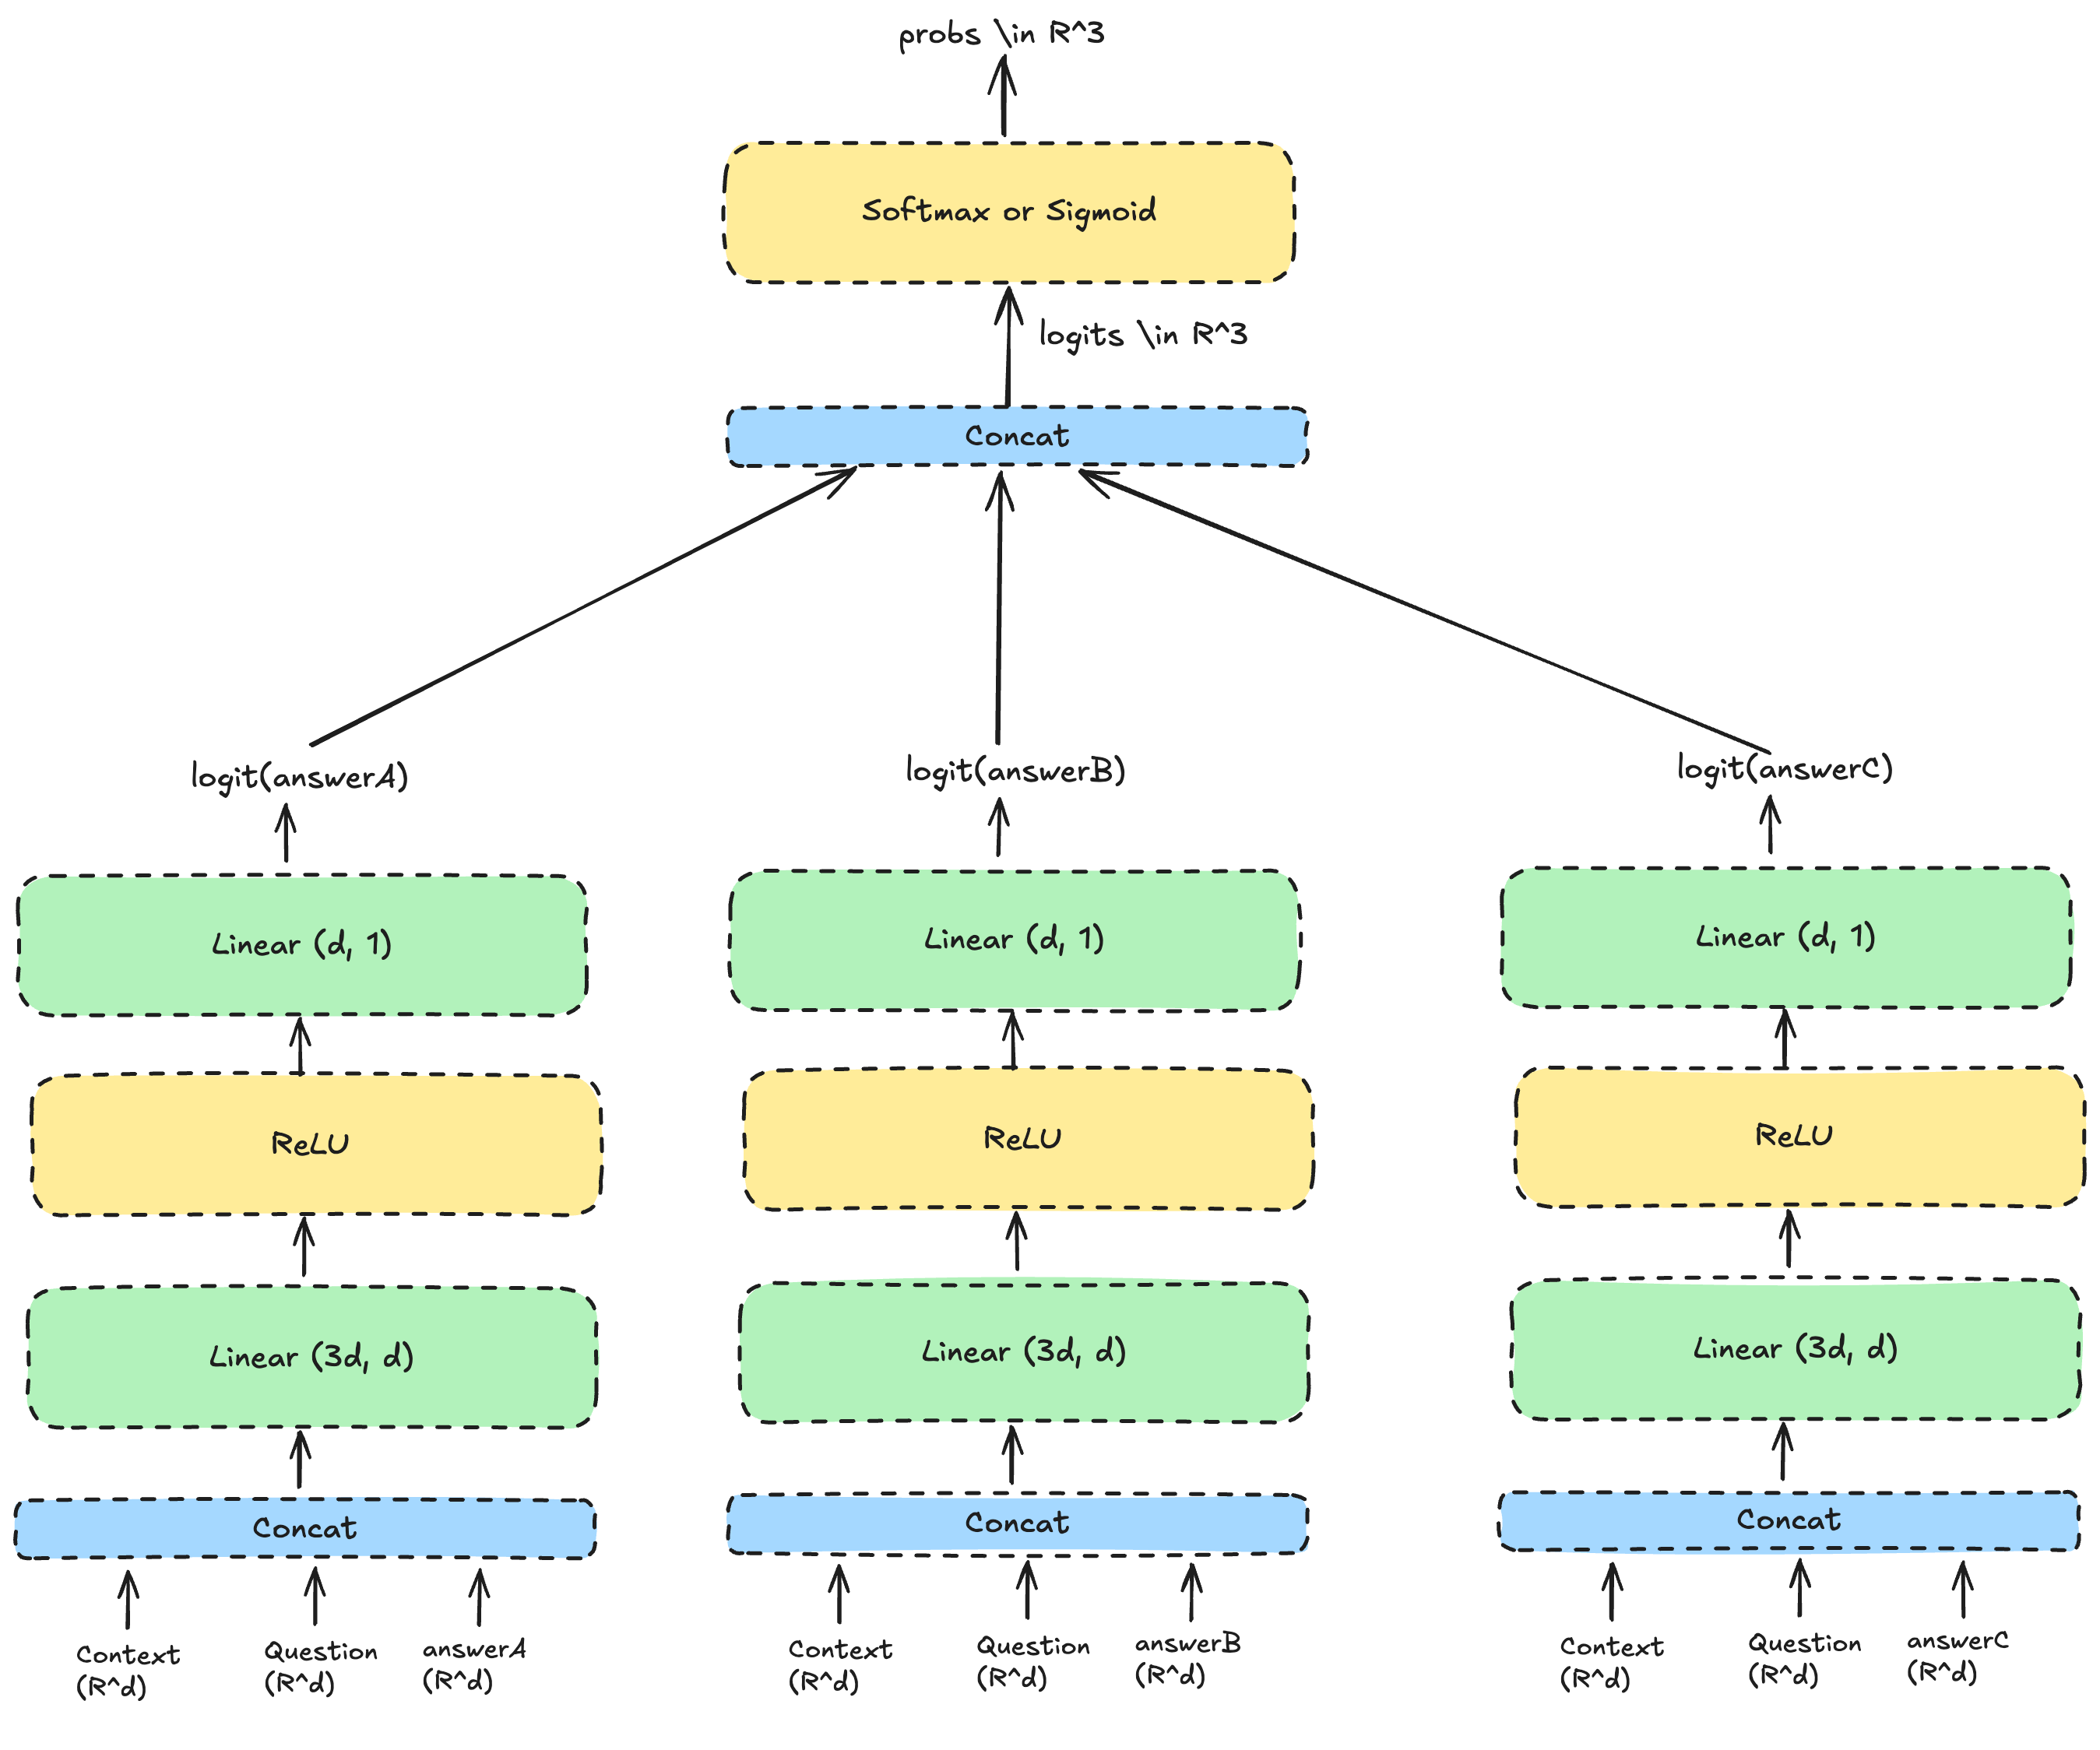

To summarize, we do three seperate forward passes through the network for each of the choices and then combine the outputs of the three forward passes to get the final output. Note that the parameters of the network are shared across the three forward passes, i.e. we pass the (context, question, choice) triplet through the same modules of the network.

The reason we do not just keep fixed 3 class labels in this case like we did in the previous exercise is because unlike sentiment classification, the meaning of the three choices is not fixed and changes from example to example. This approach also makes the network agnostic to the number as well as the order of choices (i.e. the network is equivariant to permutations of the choices).

In [ ]:
class MCQFFNN(nn.Module):

    def __init__(self, input_dim: int):
        """
        Initialize the MCQFFNN model.
        Inputs:
        - input_dim: The dimension of the sentence embeddings (this is d in the figure above)
        """

        super(MCQFFNN, self).__init__()

        # Define the architecture of the model
        self.fc1 = None
        self.act1 = None
        self.fc2 = None

        # YOUR CODE HERE
        raise NotImplementedError()
        
    def forward(self, context: torch.Tensor, question: torch.Tensor, answerA: torch.Tensor, answerB: torch.Tensor, answerC: torch.Tensor) -> torch.Tensor:
        """
        Perform a forward pass through the network.
        Inputs:
        - context: The sentence embeddings of the context
        - question: The sentence embeddings of the question
        - answerA: The sentence embeddings of answer A
        - answerB: The sentence embeddings of answer B
        - answerC: The sentence embeddings of answer C
        Returns:
        - torch.Tensor: The logits for each of the answers
        """
        
        logits = None

        # YOUR CODE HERE
        raise NotImplementedError()

        return logits

In [ ]:
exercise4 = Exercise4Runner(MCQFFNN)
exercise4.evaluate()

For test case 3, you should see that the output with permuted order is itself the same permutation of the output with the original order.

### Exercise 5: Training and Evaluating the MCQFFNN Model for Social Commonsense Reasoning

We will now train the model on the SocialIQA dataset. Note that we will be using the `CrossEntropyLoss` loss function for this task. Implement `train_siqa` and `evaluate_siqa` functions to train and evaluate the model below.

Helpful hints:
- Don't forget to get the dataloaders for the training and dev sets using the `get_siqa_dataloaders` function.
- Use `nn.CrossEntropyLoss` as the loss function.
- Use the `Adam` optimizer like before.
- For evaluation, along with the loss, we only compute the accuracy this time. The accuracy is computed as the number of correct predictions divided by the total number of predictions.

In [ ]:
def evaluate_siqa(
    model: MCQFFNN,
    dev_data_embedded: List[Dict[str, torch.Tensor]],
    dev_labels: torch.Tensor,
    eval_batch_size: int = 128,
    device: str = "cpu",
) -> Dict[str, float]:
    """
    Evaluates the model on the SocialIQA dataset.
    
    Inputs:
    - model: The MCQFFNN model
    - dev_data_embedded: List of dictionaries containing the embedded context, question and answers for the validation data
    - dev_labels: List of labels for the validation data
    - eval_batch_size: Batch size for evaluation
    - device: Device to run the evaluation on
    """

    metrics = {
        "loss": None,
        "accuracy": None,
    }

    # YOUR CODE HERE
    raise NotImplementedError()
    
    return metrics
    
def train_siqa(
    model: MCQFFNN,
    train_data_embedded: List[Dict[str, torch.Tensor]],
    train_labels: List[str],
    dev_data_embedded: List[Dict[str, torch.Tensor]],
    dev_labels: List[str],
    lr: float = 1e-3,
    batch_size: int = 32,
    eval_batch_size: int = 128,
    n_epochs: int = 10,
    device: str = "cpu",
    verbose: bool = True,
):
    """
    Runs the training loop for `n_epochs` epochs on the SocialIQA dataset.
    
    Inputs:
    - model: The MCQFFNN model to be trained
    - train_data_embedded: List of dictionaries containing the embedded context, question and answers for the training data
    - train_labels: List of labels for the training data
    - dev_data_embedded: List of dictionaries containing the embedded context, question and answers for the validation data
    - dev_labels: List of labels for the validation data
    - lr: Learning rate for the optimizer
    - n_epochs: Number of epochs to train the model
    
    Returns:
    - train_losses: List of training losses for each epoch
    - dev_metrics: List[Dict[str, float]] of validation metrics (loss, accuracy) for each epoch
    """
    # We remove all the training wheels and let you implement the training loop for the SocialIQA dataset
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return train_losses, dev_metrics

In [ ]:
exercise5 = Exercise5Runner(train_siqa, MCQFFNN=MCQFFNN, train_data_embedded=train_data_embedded, train_labels=train_labels, dev_data_embedded=dev_data_embedded, dev_labels=dev_labels)
mcqffnn, train_losses, dev_metrics = exercise5.evaluate(
    device="cpu"
)  # Change device to "cuda" if you have a GPU

You should see the following metrics at the end of training:

Here's the information in a Markdown table:

```markdown
| Metric        | Value                 |
|---------------|-----------------------|
| Training Loss | 0.6050                |
| Dev Loss      | 0.9521                |
| Dev Accuracy  | 0.5589                |
```

As you can see we get a dev accuracy of 0.56 at the end of training. This performance is quite good, considering a random guess would only give you an accuracy of 0.33 and the task is quite challenging. We can further improve the performance by also training the sentence transformer model along with the feedforward network, which is beyond the scope of this assignment. But in the next homework we will see how to train transformer models, so stay tuned!

### Exercise 6: Making Predictions

Similar to Exercise 3 for sentiment analysis, implement the `predict_siqa` function which takes in a list of contexts, questions and choices and returns the predicted choice for each context-question-choice triplet.

In [ ]:
def predict_siqa(
    siqa_cqas: List[Dict[str, str]],
    model: MCQFFNN,
    st_model: SentenceTransformer,
    batch_size: int = 32,
    device: str = "cpu",
):
    
    """
    Predicts the correct choice for the input context, question and answers.
    
    Inputs:
    
    - siqa_cqas: List of dictionaries containing the context, question, answerA, answerB and answerC
    - model: The trained MCQFFNN model
    - st_model: Sentence Transformer model to be used to embed the context, question and answers
    - batch_size: Batch size for prediction
    
    
    Returns:
    - List[str]: List of predicted answer choices
    
    Hint:
    - Convert the predicted aswers to the corresponding choice (A, B, C) using the mapping {0: "A", 1: "B", 2: "C"}
    - Do not forget to do model.eval()
    - Do not forget to use with torch.no_grad() to prevent PyTorch from storing gradients
    """
    
    label_id2label = {0: "A", 1: "B", 2: "C"}
    
    preds = []
    
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return preds

In [ ]:
print(dev_data[:2])
predict_siqa(
    dev_data[:2],
    mcqffnn,
    st_model,
    batch_size=2,
    device="cpu"
)

In [ ]:
excercise6 = Exercise6Runner(predict_siqa, mcqffnn_model=mcqffnn,)
excercise6.evaluate(device="cpu", print_q=True)

You should see the same accuracy as you saw in the previous exercise. Again, this is just to sanity check that your predict method is working correctly.